# Get boundary of Contiguous United States (CONUS) and administrative information

In [1]:
import helpers as h
import geopandas as gpd
import matplotlib.pyplot as plt


Created fresh logs/sid_2025-02-27_11-58-42_timing_results.csv
Created fresh logs/sid_2025-02-27_11-58-42_timing.log


In [2]:
tl = gpd.read_parquet('data/tl_2024_us_county.geo.parquet')

<Axes: >

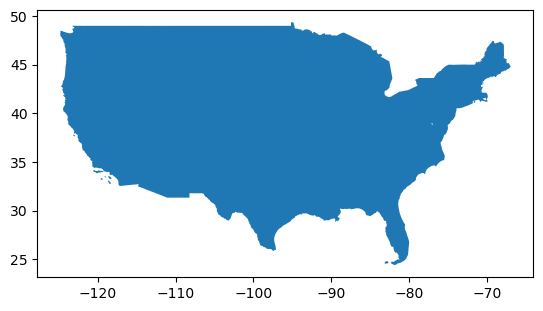

In [3]:
conus_fips = [
    '01', '04', '05', '06', '08', '09', '10', '12', '13', '16', '17', '18', '19',
    '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
    '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48',
    '49', '50', '51', '53', '54', '55', '56'
]

conus = tl[tl['STATEFP'].isin(conus_fips)]
conus_boundary = conus.dissolve()
conus_boundary.to_file('data/conus_boundary.parquet', driver='Parquet')
conus_boundary.plot()

<Axes: >

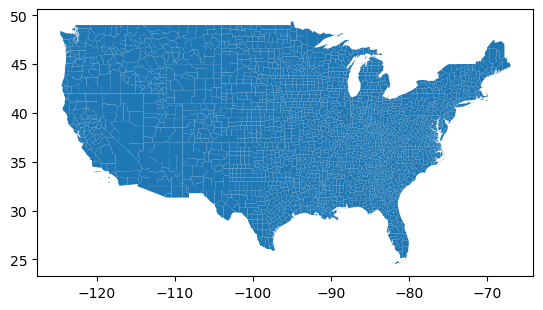

In [4]:
admin_boundaries = gpd.read_file("data/geoBoundaries-USA-ADM2.geojson")  # City, county, state
conus_boundary = conus_boundary.to_crs(epsg=4326)
admin_boundaries.to_crs(conus_boundary.crs)

conus_admin = gpd.overlay(admin_boundaries, conus_boundary, how='intersection')
conus_admin.to_parquet('data/conus_admin.parquet')
conus_admin.plot()

<Axes: >

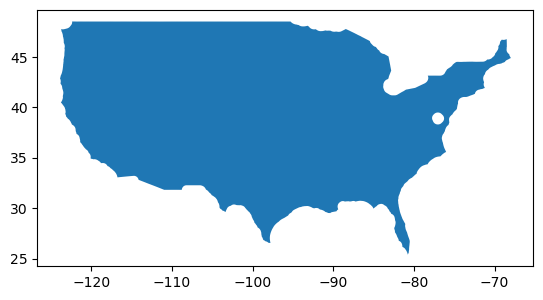

In [5]:
conus_buffer = conus_boundary.to_crs(epsg=5070) # albers equal good for U.S.
conus_buffer['geometry'] = conus_buffer.geometry.buffer(-55000) # 10km buffer
conus_buffer = conus_buffer.to_crs(epsg=4326)
conus_buffer.to_file('data/conus_buffer.parquet', driver='Parquet')
conus_buffer.plot()

Test out function:

Function `generate_random_polygons` executed in 8.9709 sec, CPU: 8.70%, Memory: 14.64MB


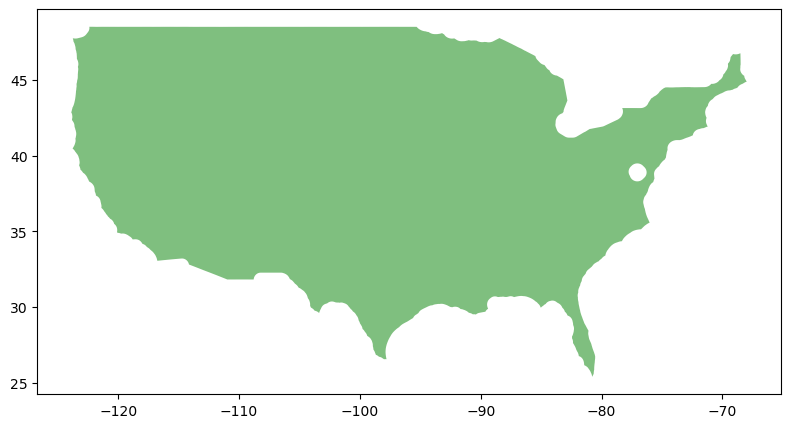

In [6]:
# Run the function
gdf = h.generate_random_polygons(n=10000, us_boundary=conus_buffer, admin_boundaries=conus_admin)

# plot the polygons
fig, ax = plt.subplots(figsize=(10, 5))
conus_buffer.plot(ax=ax, color="green", alpha=0.5)  # CONUS boundary
gdf.plot(ax=ax, color="red", alpha=0.5)  # Random polygons
plt.show()

The polygons are very small, so it's hard to see. Let's confirm that it worked:

In [7]:
gdf.head()

,geometry,id,shapeName,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,area_fips,geohash
9682,"POLYGON ((-80.92353 26.86380, -80.92353 26.864...",b1dd3c70-4dd3-4a16-98c0-2f47b0138175,Glades,31,039,31039,Cuming,Cuming County,31039,dhy2yd3w
6705,"POLYGON ((-81.12926 26.86799, -81.12926 26.868...",9aaac105-d721-498d-a21b-9c38b8dacf21,Glades,31,039,31039,Cuming,Cuming County,31039,dhy2cg5w
5741,"POLYGON ((-81.55671 26.94765, -81.55671 26.947...",683240a2-1a1c-4b61-8cac-92feb08659be,Glades,31,039,31039,Cuming,Cuming County,31039,dhy121sw
179,"POLYGON ((-81.19163 26.96893, -81.19163 26.969...",f1dc032a-65ed-4962-a97a-99fa9acf02c5,Glades,31,039,31039,Cuming,Cuming County,31039,dhy32mw5
1660,"POLYGON ((-81.33571 27.00386, -81.33571 27.004...",acc4d07b-9315-4e30-82ae-d91cda4581f0,Glades,31,039,31039,Cuming,Cuming County,31039,dhy1t5vq


Confirm area of the first polygon and the average area of the polygons:

In [10]:
area = gdf.to_crs(epsg=3857).loc[1, "geometry"].area
print(f"First polygon area: {area} square meters")

area = gdf.to_crs(epsg=3857).geometry.area
print(f'Mean polygon area:  {area.mean()} square meters')

First polygon area: 1337.1612274693223 square meters
Mean polygon area:  4901.65948271459 square meters


These are large polygons, too large for individual buildings, but for our purposes this should work.